# Multi-Fidelity Hyperparameter Optimization with Keras

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/HPS_basic_classification_with_tabular_data/notebook.ipynb)

In this tutorial we present how to use hyperparameter optimization on a basic example from the Keras documentation. We follow the previous tutorial based on the same example and add multi-fidelity to it. The purpose of multi-fidelity is to dynamically manage the budget allocated (also called fidelity) to evaluate an hyperparameter configuration. For example, when training a deep neural network the number of epochs can be continued or stopped based on currently observed performance and some policy.

In DeepHyper, the multi-fidelity agent is designed separately from the hyperparameter search agent. Of course, both can communicate but from an API perspective they are different objects. The multi-fidelity agents are called `Stopper` in DeepHyper and their documentation can be found at [deephyper.stopper](https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.stopper.html). 

In this notebook, we will demonstrate how to use multi-fidelity inside sequential Bayesian optimization. When moving to a distributed setting, it is important to use a shared database accessible by all workers otherwise the multi-fidelity scheme may not work properly. An example, of database instanciation for parallel computing is explained in: [Introduction to Distributed Bayesian Optimization (DBO) with MPI (Communication) and Redis (Storage)](https://deephyper.readthedocs.io/en/latest/tutorials/tutorials/scripts/02_Intro_to_DBO/README.html).

**Reference**:
 This tutorial is based on materials from the Keras Documentation: [Structured data classification from scratch](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/)

Let us start with installing DeepHyper!
    
<div class="alert alert-warning">

<b>Warning</b>
    
This tutorial should be run with `tensorflow>=2.6`.
    
</div>

In [1]:
# Uncomment of the following to install the required dependencies for LCModelStopper.
#!pip install "deephyper[jax-cpu]"
# or 
#!pip install "deephyper[jax-cuda]"

import deephyper
print(deephyper.__version__)

0.7.0


<div class="alert alert-info">
    
<b>Note</b>
    
The following environment variables can be used to avoid the logging of **some** Tensorflow *DEBUG*, *INFO* and *WARNING* statements.
    
</div>

In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = str(4)
os.environ["AUTOGRAPH_VERBOSITY"] = str(0)

## Imports

In [4]:
import pandas as pd
import tensorflow as tf
import tf_keras as tfk
tf.get_logger().setLevel("ERROR")

## The dataset (from Keras.io)

The [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

In [5]:
def load_data():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
    dataframe = pd.read_csv(file_url)

    val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
    train_dataframe = dataframe.drop(val_dataframe.index)

    return train_dataframe, val_dataframe


def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing & encoding of features

The next cells use `tfk.layers.Normalization()` to apply standard scaling on the features.

Then, the `tfk.layers.StringLookup` and `tfk.layers.IntegerLookup` are used to encode categorical variables.

In [6]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = tfk.layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = (
        tfk.layers.StringLookup if is_string else tfk.layers.IntegerLookup
    )
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

## Define the run-function with multi-fidelity

The run-function defines how the objective that we want to maximize is computed. It takes a `job` (see [deephyper.evaluator.RunningJob](https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.evaluator.RunningJob.html)) as input and outputs a scaler value or dictionnary (see [deephyper.evaluator](https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.evaluator.html)). The objective is always maximized in DeepHyper. The `job.parameters` contains a suggested configuration of hyperparameters that we want to evaluate. In this example we will search for:

* `units` (default value: `32`)
* `activation` (default value: `"relu"`)
* `dropout_rate` (default value: `0.5`)
* `batch_size` (default value: `32`)
* `learning_rate` (default value: `1e-3`)

A hyperparameter value can be acessed easily in the dictionary through the corresponding key, for example `job["units"]` or `job.parameters["units"]` are both valid. Unlike the previous tutorial in this example we want to use multi-fidelity to dynamically choose the allocated budget of each evaluation. Therefore we use the tensorflow keras integration of stoppers `deephyper.stopper.integration.TFKerasStopperCallback`. The multi-fidelity agent will monitor the validation accuracy (`val_accuracy`) in the context of maximization. This `stopper_callback` is then added to the callbacks used by the model during the training. In order to collect more information about the execution of our job we use the `@profile` decorator on the run-function which will collect execution timings (`timestamp_start` and `timestamp_end`). We will also add `"metadata"` to the output of our function to know how many epochs were used to evaluate each model. To learn more about how the `@profile` decorator can be used check our tutorial on [Understanding the pros and cons of Evaluator parallel backends](https://deephyper.readthedocs.io/en/latest/tutorials/tutorials/scripts/03_Evaluators/README.html).

```python
    stopper_callback = TFKerasStopperCallback(
        job, 
        monitor="val_accuracy", 
        mode="max"
    )
                                              
    history = model.fit(
        train_ds, 
        epochs=100, 
        validation_data=val_ds, 
        verbose=0,
        callbacks=[stopper_callback]
    )
    
    
    objective = history.history["val_accuracy"][-1]
    metadata = {"budget": stopper_callback.budget}
    return {"objective": objective, "metadata": metadata}
```

In [7]:
import json

from deephyper.evaluator import profile, RunningJob
from deephyper.stopper.integration.tf_keras2 import TFKerasStopperCallback


@profile
def run(job: RunningJob):
    
    config = job.parameters
    
    tf.autograph.set_verbosity(0)
    import absl.logging
    absl.logging.set_verbosity(absl.logging.ERROR)

    # Load data and split into validation set
    train_dataframe, val_dataframe = load_data()
    train_ds = dataframe_to_dataset(train_dataframe)
    val_ds = dataframe_to_dataset(val_dataframe)
    train_ds = train_ds.batch(config["batch_size"])
    val_ds = val_ds.batch(config["batch_size"])

    # Categorical features encoded as integers
    sex = tfk.Input(shape=(1,), name="sex", dtype="int64")
    cp = tfk.Input(shape=(1,), name="cp", dtype="int64")
    fbs = tfk.Input(shape=(1,), name="fbs", dtype="int64")
    restecg = tfk.Input(shape=(1,), name="restecg", dtype="int64")
    exang = tfk.Input(shape=(1,), name="exang", dtype="int64")
    ca = tfk.Input(shape=(1,), name="ca", dtype="int64")

    # Categorical feature encoded as string
    thal = tfk.Input(shape=(1,), name="thal", dtype="string")

    # Numerical features
    age = tfk.Input(shape=(1,), name="age")
    trestbps = tfk.Input(shape=(1,), name="trestbps")
    chol = tfk.Input(shape=(1,), name="chol")
    thalach = tfk.Input(shape=(1,), name="thalach")
    oldpeak = tfk.Input(shape=(1,), name="oldpeak")
    slope = tfk.Input(shape=(1,), name="slope")

    all_inputs = [
        sex,
        cp,
        fbs,
        restecg,
        exang,
        ca,
        thal,
        age,
        trestbps,
        chol,
        thalach,
        oldpeak,
        slope,
    ]

    # Integer categorical features
    sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
    cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
    fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
    restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
    exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
    ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

    # String categorical features
    thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

    # Numerical features
    age_encoded = encode_numerical_feature(age, "age", train_ds)
    trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
    chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
    thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
    oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
    slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

    all_features = tfk.layers.concatenate(
        [
            sex_encoded,
            cp_encoded,
            fbs_encoded,
            restecg_encoded,
            exang_encoded,
            slope_encoded,
            ca_encoded,
            thal_encoded,
            age_encoded,
            trestbps_encoded,
            chol_encoded,
            thalach_encoded,
            oldpeak_encoded,
        ]
    )
    x = tfk.layers.Dense(config["units"], activation=config["activation"])(
        all_features
    )
    x = tfk.layers.Dropout(config["dropout_rate"])(x)
    output = tfk.layers.Dense(1, activation="sigmoid")(x)
    model = tfk.Model(all_inputs, output)

    optimizer = tfk.optimizers.Adam(learning_rate=config["learning_rate"])
    model.compile(optimizer, "binary_crossentropy", metrics=["accuracy"])
    
    stopper_callback = TFKerasStopperCallback(
        job, 
        monitor="val_accuracy", 
        mode="max"
    )
                                              
    history = model.fit(
        train_ds, 
        epochs=100, 
        validation_data=val_ds, 
        verbose=0,
        callbacks=[stopper_callback]
    )
    
    
    objective = history.history["val_accuracy"][-1]
    metadata = {
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
    }
    metadata = {k:json.dumps(v) for k,v in metadata.items()}
    metadata["budget"] = stopper_callback.budget
    return {"objective": objective, "metadata": metadata}

<div class="alert alert-info"> 
<b>Note</b>  
<br>

The objective maximized by DeepHyper is the `"objective"` value returned by the `run`-function.
    
</div>

In this tutorial it corresponds to the validation accuracy of the last epoch of training which we retrieve in the `History` object returned by the `model.fit(...)` call.
    
```python
...
objective = history.history["val_accuracy"][-1]
...
``` 
    
Using an objective like `max(history.history['val_accuracy'])` can have undesired side effects.

For example, it is possible that the training curves will overshoot a local maximum, resulting in a model without the capacity to flexibly adapt to new data in the future.

## Define the Hyperparameter optimization problem

Hyperparameter ranges are defined using the following syntax:

* Discrete integer ranges are generated from a tuple `(lower: int, upper: int)`
* Continuous prarameters are generated from a tuple `(lower: float, upper: float)`
* Categorical or nonordinal hyperparameter ranges can be given as a list of possible values `[val1, val2, ...]`


In [8]:
from deephyper.hpo import HpProblem


# Creation of an hyperparameter problem
problem = HpProblem()

# Discrete hyperparameter (sampled with uniform prior)
problem.add_hyperparameter((8, 128), "units", default_value=32)


# Categorical hyperparameter (sampled with uniform prior)
ACTIVATIONS = [
    "elu", "gelu", "hard_sigmoid", "linear", "relu", "selu",
    "sigmoid", "softplus", "softsign", "swish", "tanh",
]
problem.add_hyperparameter(ACTIVATIONS, "activation", default_value="relu")


# Real hyperparameter (sampled with uniform prior)
problem.add_hyperparameter((0.0, 0.6), "dropout_rate", default_value=0.5)


# Discrete and Real hyperparameters (sampled with log-uniform)
problem.add_hyperparameter((8, 256, "log-uniform"), "batch_size", default_value=32)
problem.add_hyperparameter((1e-5, 1e-2, "log-uniform"), "learning_rate", default_value=1e-3)

problem

Configuration space object:
  Hyperparameters:
    activation, Type: Categorical, Choices: {elu, gelu, hard_sigmoid, linear, relu, selu, sigmoid, softplus, softsign, swish, tanh}, Default: relu
    batch_size, Type: UniformInteger, Range: [8, 256], Default: 32, on log-scale
    dropout_rate, Type: UniformFloat, Range: [0.0, 0.6], Default: 0.5
    learning_rate, Type: UniformFloat, Range: [1e-05, 0.01], Default: 0.001, on log-scale
    units, Type: UniformInteger, Range: [8, 128], Default: 32

## Evaluate a default configuration

We evaluate the performance of the default set of hyperparameters provided in the Keras tutorial.

In [11]:
out = run(RunningJob(parameters=problem.default_configuration))
objective_default = out["objective"]
metadata_default = out["metadata"]
    
print(f"Accuracy of the default configuration is {objective_default:.3f} with a budget of {metadata_default['budget']} epochs.")

out

Accuracy of the default configuration is 0.803 with a budget of 100 epochs.


{'objective': 0.8032786846160889,
 'metadata': {'timestamp_start': 1723023300.917484,
  'timestamp_end': 1723023304.245575,
  'loss': '[0.7362097501754761, 0.6697641015052795, 0.6145583987236023, 0.5789035558700562, 0.5735929012298584, 0.5361037254333496, 0.4895346164703369, 0.5042304396629333, 0.47402769327163696, 0.45491307973861694, 0.43374136090278625, 0.4440498352050781, 0.418672651052475, 0.41186368465423584, 0.3983386158943176, 0.3848767876625061, 0.3917289972305298, 0.3652024269104004, 0.3700634241104126, 0.3620007038116455, 0.3734380900859833, 0.3646697998046875, 0.3320537805557251, 0.3205015957355499, 0.3334946632385254, 0.32958391308784485, 0.35067492723464966, 0.31872624158859253, 0.3393949270248413, 0.3254067003726959, 0.30296456813812256, 0.3285101354122162, 0.3165312707424164, 0.3480093777179718, 0.28826412558555603, 0.2984684109687805, 0.32645756006240845, 0.3101368546485901, 0.3060572147369385, 0.2771577537059784, 0.2963084578514099, 0.3041466474533081, 0.2854392230510

## Execute Multi-Fidelity Bayesian Optimization

We create the CBO using the `problem` and `run`-function defined above. When directly passing the `run`-function to the search it is wrapped inside a [deephyper.evaluator.SerialEvaluator](https://deephyper.readthedocs.io/en/latest/_autosummary/deephyper.evaluator.SerialEvaluator.html). Then, we also import the [deephyper.stopper.SuccessiveHalvingStopper](https://deephyper.readthedocs.io/en/develop/_autosummary/deephyper.stopper.LCModelStopper.html#deephyper.stopper.SuccessiveHalvingStopper).

In [42]:
from deephyper.hpo import CBO

# Different stoppers can be used
# from deephyper.stopper import SuccessiveHalvingStopper
# from deephyper.stopper import MedianStopper
from deephyper.stopper import LCModelStopper
# from deephyper.stopper import ConstantStopper


# Instanciate the search with the problem and the evaluator that we created before

max_steps = 100
# stopper = SuccessiveHalvingStopper(max_steps=100)
# stopper = MedianStopper(max_steps=100)
stopper = LCModelStopper(max_steps=max_steps, lc_model="pow3")
# stopper = ConstantStopper(max_steps=10)

search = CBO(
    problem,
    run,
    initial_points=[problem.default_configuration],
    stopper=stopper,
    acq_optimizer="mixedga",
    acq_optimizer_freq=1,
    verbose=1,
)

<div class="alert alert-info">
    
<b>Note</b>
    
All DeepHyper's search algorithm have two stopping criteria:
    <ul> 
        <li> <code>`max_evals (int)`</code>: Defines the maximum number of evaluations that we want to perform. Default to <code>-1</code> for an infinite number.</li>
        <li> <code>`timeout (int)`</code>: Defines a time budget (in seconds) before stopping the search. Default to <code>None</code> for an infinite time budget.</li>
    </ul>
    
</div>

In [43]:
results = search.search(max_evals=100)

  0%|          | 0/100 [00:00<?, ?it/s]

The returned `results` is a Pandas Dataframe where columns starting by `"p:"` are hyperparameters, columns starting by `"m:"` are additional metadata (from the user or from the `Evaluator`) as well as the `objective` value and the `job_id`:

* `job_id` is a unique identifier corresponding to the order of creation of tasks.
* `objective` is the value returned by the run-function.
* `m:timestamp_submit` is the time (in seconds) when the task was created by the evaluator since the creation of the evaluator.
* `m:timestamp_gather` is the time (in seconds) when the task was received after finishing by the evaluator since the creation of the evaluator.
* `m:timestamp_start` is the time (in seconds) when the task started to run.
* `m:timestamp_end` is the time (in seconds) when task finished to run.
* `m:budget` is the consumed number of epoch for each evaluation.

In [44]:
results

,p:activation,p:batch_size,p:dropout_rate,p:learning_rate,p:units,objective,job_id,m:timestamp_submit,m:timestamp_start,m:timestamp_end,m:loss,m:val_loss,m:accuracy,m:val_accuracy,m:budget,m:timestamp_gather
0,relu,32,0.500000,0.001000,32,0.803279,0,1.932499,1.723025e+09,1.723025e+09,"[0.6870811581611633, 0.6041032671928406, 0.588...","[0.5393993258476257, 0.49195191264152527, 0.45...","[0.5826446413993835, 0.6652892827987671, 0.690...","[0.8196721076965332, 0.8196721076965332, 0.819...",4,4.575039
1,gelu,115,0.005366,0.000032,36,0.262295,1,4.597510,1.723025e+09,1.723025e+09,"[0.7932556867599487, 0.7905817627906799, 0.792...","[0.8366922736167908, 0.835249125957489, 0.8338...","[0.3264462947845459, 0.3264462947845459, 0.330...","[0.26229506731033325, 0.26229506731033325, 0.2...",4,6.996613
2,linear,69,0.233517,0.000354,96,0.836066,2,7.015395,1.723025e+09,1.723025e+09,"[0.7108834981918335, 0.6619299054145813, 0.627...","[0.6106250882148743, 0.5766424536705017, 0.547...","[0.5330578684806824, 0.6363636255264282, 0.652...","[0.6721311211585999, 0.7213114500045776, 0.754...",50,45.511663
3,tanh,15,0.273941,0.000113,61,0.754098,3,45.530339,1.723025e+09,1.723025e+09,"[0.6873517632484436, 0.6642571091651917, 0.620...","[0.6695288419723511, 0.6443946361541748, 0.623...","[0.5785123705863953, 0.6322314143180847, 0.669...","[0.6393442749977112, 0.688524603843689, 0.7049...",5,48.626558
4,sigmoid,18,0.166749,0.000030,119,0.229508,4,48.645619,1.723025e+09,1.723025e+09,"[1.1257368326187134, 1.1016931533813477, 1.078...","[1.1645071506500244, 1.1460453271865845, 1.128...","[0.2851239740848541, 0.2851239740848541, 0.285...","[0.2295081913471222, 0.2295081913471222, 0.229...",4,50.913847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,tanh,142,0.080719,0.000606,120,0.836066,95,1658.053549,1.723027e+09,1.723027e+09,"[0.7016527056694031, 0.6609528660774231, 0.634...","[0.6817922592163086, 0.6379983425140381, 0.599...","[0.5537189841270447, 0.6239669322967529, 0.657...","[0.6229507923126221, 0.6557376980781555, 0.704...",15,1668.963508
96,swish,111,0.082582,0.000545,120,0.836066,96,1669.753532,1.723027e+09,1.723027e+09,"[0.6840658187866211, 0.649455189704895, 0.6178...","[0.6673111915588379, 0.6365963816642761, 0.608...","[0.5165289044380188, 0.6280992031097412, 0.719...","[0.6229507923126221, 0.6721311211585999, 0.737...",43,1702.570466
97,swish,110,0.153530,0.000800,120,0.836066,97,1703.020329,1.723027e+09,1.723027e+09,"[0.6909340023994446, 0.6351671814918518, 0.606...","[0.6330044269561768, 0.5874522924423218, 0.549...","[0.5619834661483765, 0.702479362487793, 0.6983...","[0.688524603843689, 0.7868852615356445, 0.8032...",43,1741.469583
98,softsign,133,0.083265,0.000591,120,0.852459,98,1742.164090,1.723027e+09,1.723027e+09,"[0.7040019631385803, 0.6649524569511414, 0.645...","[0.6937681436538696, 0.6623088121414185, 0.633...","[0.4834710657596588, 0.5826446413993835, 0.628...","[0.5409836173057556, 0.6393442749977112, 0.704...",55,1785.587375


Now that the search is over, let us print the best configuration found during this run.

In [45]:
i_max = results.objective.argmax()
best_job = results.iloc[i_max].to_dict()


print(f"The default configuration has an accuracy of {objective_default:.3f}. \n" 
      f"The best configuration found by DeepHyper has an accuracy {results['objective'].iloc[i_max]:.3f}, \n" 
      f"discovered after {results['m:timestamp_gather'].iloc[i_max]:.2f} secondes of search.\n")

best_job

The default configuration has an accuracy of 0.803. 
The best configuration found by DeepHyper has an accuracy 0.869, 
discovered after 334.69 secondes of search.



{'p:activation': 'swish',
 'p:batch_size': 77,
 'p:dropout_rate': 0.1609926444864691,
 'p:learning_rate': 0.0023116936260455,
 'p:units': 122,
 'objective': 0.868852436542511,
 'job_id': 19,
 'm:timestamp_submit': 328.612468957901,
 'm:timestamp_start': 1723025443.263885,
 'm:timestamp_end': 1723025449.34447,
 'm:loss': '[0.690102756023407, 0.5534645915031433, 0.475394070148468, 0.42763301730155945, 0.39225339889526367, 0.3725284934043884, 0.3520734906196594, 0.34315618872642517, 0.3243461847305298]',
 'm:val_loss': '[0.5625881552696228, 0.46320250630378723, 0.4091970920562744, 0.38046151399612427, 0.364383727312088, 0.3571088910102844, 0.35642480850219727, 0.3613392114639282, 0.37086689472198486]',
 'm:accuracy': '[0.5289255976676941, 0.7479338645935059, 0.7561983466148376, 0.7809917330741882, 0.78925621509552, 0.8181818127632141, 0.8388429880142212, 0.8512396812438965, 0.8471074104309082]',
 'm:val_accuracy': '[0.8360655903816223, 0.8360655903816223, 0.8196721076965332, 0.78688526153

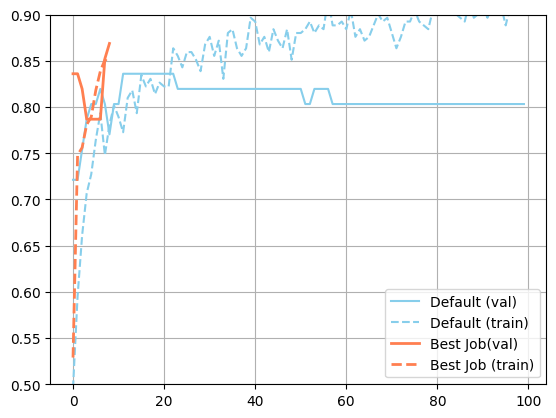

In [46]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.plot(json.loads(metadata_default["val_accuracy"]), color="skyblue", label="Default (val)")
plt.plot(json.loads(metadata_default["accuracy"]), color="skyblue", linestyle="--", label="Default (train)")
plt.plot(json.loads(best_job["m:val_accuracy"]), color="coral", linewidth=2, label="Best Job(val)")
plt.plot(json.loads(best_job["m:accuracy"]), color="coral", linestyle="--", linewidth=2, label="Best Job (train)")
plt.legend()
plt.ylim(0.5, 0.9)
plt.grid()
plt.show()

We can observe an improvement of more than 3% in accuracy. We can retrieve the corresponding hyperparameter configuration with the number of epochs used for this evaluation (32).

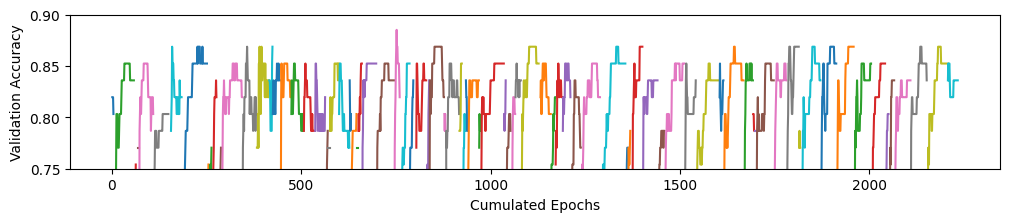

In [48]:
plt.figure(figsize=(12, 2))
cumulated_budget = 1
for i, job in results.iterrows():
    val_accuracy = json.loads(job["m:val_accuracy"])
    x = np.arange(len(val_accuracy)) + cumulated_budget
    cumulated_budget += len(val_accuracy)
    plt.plot(x, val_accuracy, label=f"Job {i}")
plt.ylabel("Validation Accuracy")
plt.xlabel("Cumulated Epochs")
plt.ylim(0.75, 0.9)
plt.show()